# Announcement-on-ML
<a href='http://www.kgptalkie.com' target="_blank"> <img src='https://github.com/laxmimerit/Important-Announcement-on-ML/raw/master/kgptalkie_strips.png'/></a>

# ML Resources
|  ML Course | Description |
|:---|:---|
| [**Fine Tuning LLM with HuggingFace Transformers for NLP**](https://www.udemy.com/course/fine-tuning-llm-with-hugging-face-transformers/?referralCode=6DEB3BE17C2644422D8E) | Learn how to fine tune LLM with custom dataset. You will learn basics of transformers then fine tune LLM|
| [**Data Visualization in Python Masterclass™: Beginners to Pro**](https://bit.ly/udemy95off_kgptalkie) |  Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Python for Machine Learning: A Step-by-Step Guide**](https://bit.ly/ml-ds-project) | Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Deep Learning for Beginners with Python**](https://bit.ly/dl-with-python) | Neural Networks, TensorFlow, ANN, CNN, RNN, LSTM, Transfer Learning and Much More. |
| [**Python for Linear Regression in Machine Learning**](https://bit.ly/regression-python) | Learn to build Linear Regression models using Python and its libraries like Scikit-Learn. |
| [**Introduction to Spacy 3 for Natural Language Processing**](https://bit.ly/spacy-intro) | Learn to build Natural Language Processing models using Python and its libraries like Spacy. |
| [**Advanced Machine Learning and Deep Learning Projects**](https://bit.ly/kgptalkie_ml_projects) | Learn to build Advanced Machine Learning and Deep Learning models using Python and transformer models like BERT, GPT-2, and XLNet. |
| [**Natural Language Processing in Python for Beginners**](https://bit.ly/intro_nlp) | Learn to build Natural Language Processing Projects using Spacy, NLTK, and Gensim, and transformer models like BERT, GPT-2, and XLNet. |
| [**Deployment of Machine Learning Models in Production in Python**](https://bit.ly/bert_nlp) |  Learn to deploy Machine Learning and Deep Learning models using Python and its libraries like Flask, Streamlit, and NGINX. |
| [**R 4.0 Programming for Data Science - Beginners to Pro**](https://bit.ly/r4-ml) | Learn to build Machine Learning and Deep Learning models using R and its libraries like caret, tidyverse, and keras. |


# Image classification

## Load Indian Food Dataset

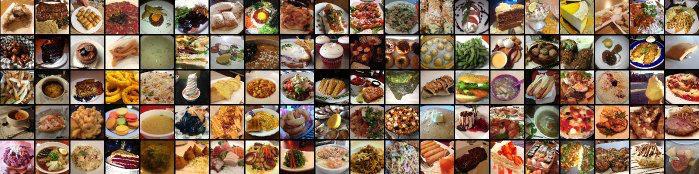

In [1]:
# !pip install datasets
# !pip install -U accelerate
# !pip install evaluate

import warnings
warnings.filterwarnings('ignore')


In [2]:
from datasets import load_dataset


food = load_dataset("rajistics/indian_food_images")


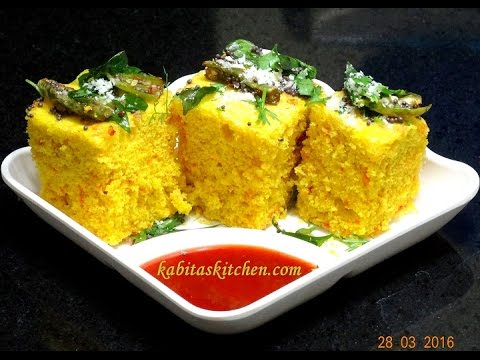

In [5]:
food['train'][0]['image'] # class id => 6

In [9]:
labels = food['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'burger': 0, 'butter_naan': 1, 'chai': 2, 'chapati': 3, 'chole_bhature': 4, 'dal_makhani': 5, 'dhokla': 6, 'fried_rice': 7, 'idli': 8, 'jalebi': 9, 'kaathi_rolls': 10, 'kadai_paneer': 11, 'kulfi': 12, 'masala_dosa': 13, 'momos': 14, 'paani_puri': 15, 'pakode': 16, 'pav_bhaji': 17, 'pizza': 18, 'samosa': 19}
{0: 'burger', 1: 'butter_naan', 2: 'chai', 3: 'chapati', 4: 'chole_bhature', 5: 'dal_makhani', 6: 'dhokla', 7: 'fried_rice', 8: 'idli', 9: 'jalebi', 10: 'kaathi_rolls', 11: 'kadai_paneer', 12: 'kulfi', 13: 'masala_dosa', 14: 'momos', 15: 'paani_puri', 16: 'pakode', 17: 'pav_bhaji', 18: 'pizza', 19: 'samosa'}


## Preprocessing and Evaluator

In [11]:
from transformers import AutoImageProcessor

model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

In [14]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size['shorted_edge']
    if "shorted_edge" in image_processor.size
    else (image_processor.size['height'], image_processor.size['width'])
)


_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples['pixel_values'] = [_transforms(img.convert('RGB')) for img in examples['image']]
    del examples['image']

    return examples


In [15]:
food = food.with_transform(transforms)

## Evaluate the model

In [16]:
import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)


## Vision Transformer (ViT) Fine Tuning

In [17]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label=id2label,
    label2id=label2id
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

args = TrainingArguments(
    output_dir = "train_dir",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=4,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=food['train'],
    eval_dataset=food['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

trainer.train()


  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.627604603767395, 'eval_accuracy': 0.822529224229543, 'eval_runtime': 20.8172, 'eval_samples_per_second': 45.203, 'eval_steps_per_second': 2.834, 'epoch': 1.0}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.10537850856781, 'eval_accuracy': 0.8809776833156217, 'eval_runtime': 20.7972, 'eval_samples_per_second': 45.247, 'eval_steps_per_second': 2.837, 'epoch': 1.99}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.9265485405921936, 'eval_accuracy': 0.8905419766206164, 'eval_runtime': 21.0412, 'eval_samples_per_second': 44.722, 'eval_steps_per_second': 2.804, 'epoch': 2.99}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.8885676860809326, 'eval_accuracy': 0.8894792773645058, 'eval_runtime': 20.5608, 'eval_samples_per_second': 45.767, 'eval_steps_per_second': 2.87, 'epoch': 3.99}
{'train_runtime': 928.8633, 'train_samples_per_second': 22.944, 'train_steps_per_second': 0.357, 'train_loss': 1.3233869621552616, 'epoch': 3.99}


TrainOutput(global_step=332, training_loss=1.3233869621552616, metrics={'train_runtime': 928.8633, 'train_samples_per_second': 22.944, 'train_steps_per_second': 0.357, 'total_flos': 1.646815430420988e+18, 'train_loss': 1.3233869621552616, 'epoch': 3.987987987987988})

In [21]:
trainer.save_model('food_classification')

## Inference

In [23]:
from transformers import pipeline

pipe = pipeline("image-classification", model='food_classification', device=device)

In [24]:
import requests
from PIL import Image
from io import BytesIO

url = 'https://www.indianhealthyrecipes.com/wp-content/uploads/2015/10/pizza-recipe-1.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.show()

In [25]:
pipe(image)

[{'label': 'pizza', 'score': 0.5428637862205505},
 {'label': 'kadai_paneer', 'score': 0.03565927594900131},
 {'label': 'pav_bhaji', 'score': 0.03565794229507446},
 {'label': 'butter_naan', 'score': 0.028422074392437935},
 {'label': 'burger', 'score': 0.027608927339315414}]

In [26]:
labels

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']